<a href="https://colab.research.google.com/github/em-chiu/intersection_project/blob/main/EC%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import urllib.request
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
import re
import numpy as np
from collections import Counter
from sklearn import preprocessing
import string
nltk.download('averaged_perceptron_tagger') # to solve pos feature extract issue
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

import pandas as pd # data processing
import csv
from bs4 import BeautifulSoup
import sys
import unidecode
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emilychiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# import os
# data_dir = '../data/'
# or_fname = 'FTR_new_labels.csv'
# fname = data_dir+or_fname


# load the data to df, try1 works
df = pd.read_csv('FTR_labels_copy.csv', header=None, encoding = "ISO-8859-1")\
        .drop(0, axis=1)\
        .rename(columns={1: 'tweet'})

In [3]:
# preview data
df.head()

tweet      2
0                                              tweet  label
1  Elle ne devait pas dÃ©gager la nazi ??? https:...      1
2  je dois faire un oral en anglais sur Hitler et...      0
3  @ambrassmoi_ A Ã§a ð¤ de ressembler Ã  la cr...      0
4  "Par curiositÃ©, jâai voulu Ã©couter les dis...      0

In [4]:
# Drop first row 
# by selecting all rows from first row onwards
df = df.iloc[1: , :]

In [5]:
# view dimensions of dataset
df.shape
# 2857 instances and 2 attributes in dataset

(2856, 2)

In [6]:
# Rename column names
col_names = ['tweet', 'label']
df.columns = col_names
df.columns

Index(['tweet', 'label'], dtype='object')

In [7]:
# preview after renaming
df.head()

tweet label
1  Elle ne devait pas dÃ©gager la nazi ??? https:...     1
2  je dois faire un oral en anglais sur Hitler et...     0
3  @ambrassmoi_ A Ã§a ð¤ de ressembler Ã  la cr...     0
4  "Par curiositÃ©, jâai voulu Ã©couter les dis...     0
5  @tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...     1

In [8]:
# summary of data
df.info()
# no missing data
# Categorical variables have data type object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 1 to 2856
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2856 non-null   object
 1   label   2856 non-null   object
dtypes: object(2)
memory usage: 44.8+ KB


In [9]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['tweet', 'label']


In [10]:
# view the categorical variables
df[categorical].head()

tweet label
1  Elle ne devait pas dÃ©gager la nazi ??? https:...     1
2  je dois faire un oral en anglais sur Hitler et...     0
3  @ambrassmoi_ A Ã§a ð¤ de ressembler Ã  la cr...     0
4  "Par curiositÃ©, jâai voulu Ã©couter les dis...     0
5  @tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...     1

In [11]:
# check missing values in categorical variables
df[categorical].isnull().sum()

tweet    0
label    0
dtype: int64

In [12]:
# view frequency counts of values in categorical variables
for var in categorical: 
    print(df[var].value_counts())

# 0        1929
# 1         927

"0. Moi\n                                                                                                                                                    4
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   2
"ððððð\n                                                                                                                                      2
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    2
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        2
                                                                                                                                                            ..
de toutes faÃ§ons, c'est une mascarade. person

In [13]:
# view frequency distribution of categorical variables
for var in categorical:   
    print(df[var].value_counts()/float(len(df)))

"0. Moi\n                                                                                                                                                    0.001401
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   0.000700
"ððððð\n                                                                                                                                      0.000700
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    0.000700
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        0.000700
                                                                                                                                                               ...   
de t

In [14]:
# # check frequency distribution of values in label variable
df.label.value_counts()

0    1929
1     927
Name: label, dtype: int64

In [50]:
# Lowercase all words
def make_lower(a_string):
    return a_string.lower()

df['lowered_tweet'] = df['tweet'].apply(make_lower)
df['lowered_tweet']

1       elle ne devait pas dã©gager la nazi ??? https:...
2       je dois faire un oral en anglais sur hitler et...
3       @ambrassmoi_ a ã§a ð¤ de ressembler ã  la cr...
4       "par curiositã©, jâai voulu ã©couter les dis...
5       @tical10 @exbarcafan74523 @conflitsfrance mdr ...
                              ...                        
2852                           kevin câest un sal noir.
2853    bougnoule bamboula sale arabe , elle est belle...
2854      @b_mahrezz tu viens de le traiter de sal noir ?
2855                     sal noir https://t.co/jraabftel8
2856    sal noir https://t.co/9sr7f4mzr5 https://t.co/...
Name: lowered_tweet, Length: 2856, dtype: object

In [ ]:
from bs4 import BeautifulSoup

def tweet_cleaner(text, my_dict, stem = False):
        
    # fixes encoding problem (MICHELE)
    if sys.version_info[0] < 3:
        if type(text)!=unicode and type(text)!=float:
            try: 
                text= unicode(text,'utf-8')
            except UnicodeDecodeError: 
                text= unicode(text,'latin-1')
    if type(text)==float:
        text = str(text)
    
    if stem:
        stemmer = FrenchStemmer()
        tokens = [stemmer.stem(t) for t in text.split() if len(stemmer.stem(t))>=1]
        text = " ".join(tokens)
    
    tok = WordPunctTokenizer()

    pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
    rt_path = r'^rt'
    paths =  [combined_pat, www_pat,rt_path ]
    
        
#     text = unidecode.unidecode(text)
#     soup = BeautifulSoup(text, 'lxml')
#     souped = soup.get_text()
#     lower = souped.lower()
    
#     for word in my_dict:
#         souped = re.sub(word, my_dict[word], text)#, lower)
    
#     try:
#         bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
#     except:
#         bom_removed = souped
    
#     for path in paths:
#         bom_removed = re.sub(path, '', bom_removed.lower())
    
#     letters_only = re.sub("[^a-zA-Z]", " ", bom_removed)
    
 
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) >= 1]
    return (" ".join(words)).strip()

my_dict={"aujourd'hui":"aujourdhui", "s'il":"si il", "s'":"se ","n'":"ne ", 'jte':"je te", 'pck':'parce que', 'jms':'jamais',
        'fdp': 'fis de pute', 'ptn': 'putaine', 'pcq':'parce que', 'tt ': 'toute', 'vrmt': 'vraiment',
         "m'a'": 'me a','ptdr':" plie tordu de rire", "c'est":"ce est","m'":"me ", "jrnee":"jourrnee",'pxtain': 'putaine', 'bz':'baisez', "j'":"je ", "qu'":"que "}

In [51]:
# Remove all punctuation
def remove_punctuation(a_string):    
    a_string = re.sub(r'[^\w\s]','',a_string)
    return a_string

df['remove_punctuation'] = df['lowered_tweet'].apply(remove_punctuation)
df['remove_punctuation']

# do I want to remove puncutation???

1       elle ne devait pas dãgager la nazi  httpstcona...
2       je dois faire un oral en anglais sur hitler et...
3       ambrassmoi_ a ãa ð de ressembler ã  la croix n...
4       par curiositã jâai voulu ãcouter les discours ...
5       tical10 exbarcafan74523 conflitsfrance mdr deu...
                              ...                        
2852                              kevin câest un sal noir
2853    bougnoule bamboula sale arabe  elle est belle ...
2854        b_mahrezz tu viens de le traiter de sal noir 
2855                          sal noir httpstcojraabftel8
2856       sal noir httpstco9sr7f4mzr5 httpstco53f9rbpjsf
Name: remove_punctuation, Length: 2856, dtype: object

In [48]:
tokenizer = nltk.TweetTokenizer()
# keeps hashtags together, subset of word_tokenize

df['tokenized_tweet'] = df['lowered_tweet'].apply(tokenizer.tokenize)
df.head()

# https://stackoverflow.com/questions/48363461/passing-a-pandas-dataframe-column-to-an-nltk-tokenizer
#df['tweet'] = df['tweet'].apply(nltk.TweetTokenizer)
# this overwrote what i did

tweet label  \
1  Elle ne devait pas dÃ©gager la nazi ??? https:...     1   
2  je dois faire un oral en anglais sur Hitler et...     0   
3  @ambrassmoi_ A Ã§a ð¤ de ressembler Ã  la cr...     0   
4  "Par curiositÃ©, jâai voulu Ã©couter les dis...     0   
5  @tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...     1   

                                     tokenized_tweet  \
1  [elle, ne, devait, pas, dã, ©, gager, la, nazi...   
2  [je, dois, faire, un, oral, en, anglais, sur, ...   
3  [@ambrassmoi_, a, ã, §, a, ð, , ¤, , de, res...   
4  [", par, curiositã, ©, ,, jâ, , , ai, voulu,...   
5  [@tical10, @exbarcafan74523, @conflitsfrance, ...   

                                       lowered_tweet  
1  elle ne devait pas dã©gager la nazi ??? https:...  
2  je dois faire un oral en anglais sur hitler et...  
3  @ambrassmoi_ a ã§a ð¤ de ressembler ã  la cr...  
4  "par curiositã©, jâai voulu ã©couter les dis...  
5  @tical10 @exbarcafan74523 @conflitsfrance mdr ...

In [242]:
df['tweet'] = df['tweet'].astype(pd.StringDtype())
df['tweet']
# must feed str into vectorizer

1       <nltk.tokenize.casual.TweetTokenizer object at...
2       <nltk.tokenize.casual.TweetTokenizer object at...
3       <nltk.tokenize.casual.TweetTokenizer object at...
4       <nltk.tokenize.casual.TweetTokenizer object at...
5       <nltk.tokenize.casual.TweetTokenizer object at...
                              ...                        
2852    <nltk.tokenize.casual.TweetTokenizer object at...
2853    <nltk.tokenize.casual.TweetTokenizer object at...
2854    <nltk.tokenize.casual.TweetTokenizer object at...
2855    <nltk.tokenize.casual.TweetTokenizer object at...
2856    <nltk.tokenize.casual.TweetTokenizer object at...
Name: tweet, Length: 2856, dtype: string

In [16]:
def generate_stopwords():
    stopwords_en = nltk.corpus.stopwords.words("english")
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    other_exclusions = ["les"]
    stop_words.extend(other_exclusions)
    return stop_words

def remove_stopwords(text_list, sw):
    return [word for word in text_list if word not in sw]

In [19]:
allstopwords = generate_stopwords()
allstopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
remove_stopwords(df['tokenized_tweet'], allstopwords)

[['Elle',
  'ne',
  'devait',
  'pas',
  'dÃ',
  '©',
  'gager',
  'la',
  'nazi',
  '?',
  '?',
  '?',
  'https://t.co/NAGVyrhsXy'],
 ['je',
  'dois',
  'faire',
  'un',
  'oral',
  'en',
  'anglais',
  'sur',
  'Hitler',
  'et',
  'sa',
  'propagande',
  'pour',
  'la',
  'section',
  'euro',
  'Ã',
  '§',
  'a',
  'sâ',
  '\x80',
  '\x99',
  'annonce',
  'compliquÃ',
  '©',
  'e'],
 ['@ambrassmoi_',
  'A',
  'Ã',
  '§',
  'a',
  'ð',
  '\x9f',
  '¤',
  '\x8f',
  'de',
  'ressembler',
  'Ã',
  'la',
  'croix',
  'nazi',
  'mdrr'],
 ['"',
  'Par',
  'curiositÃ',
  '©',
  ',',
  'jâ',
  '\x80',
  '\x99',
  'ai',
  'voulu',
  'Ã',
  '©',
  'couter',
  'les',
  'discours',
  'longs',
  'de',
  'Hitlerâ',
  '\x80',
  '¦',
  '.',
  'on',
  'en',
  'trouve',
  'sur',
  'internet',
  'mais',
  'pas',
  'sur',
  'YouTube',
  '.'],
 ['@tical10',
  '@ExBarcaFan74523',
  '@ConflitsFrance',
  'Mdr',
  'deux',
  'nazi',
  'n',
  'importe',
  'quoi',
  'ð',
  '\x9f',
  '¤',
  '¦',
  'ð',
  '\x9f',


In [ ]:
# PROCESS DATA E.G. CLEANING 

In [30]:
df['tokenized_tweet'] = df['tokenized_tweet'].astype(str)

In [31]:
X = df['tokenized_tweet'] # list of tokenized tweets
y = df['label'] # list of labels of tweets

In [32]:
# split X and y into training and testing sets
# randomizes data in splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# indicating random state ensures data split will be same
#https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn

In [33]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape
# ((2284, 10), (572, 10))

((2284,), (572,))

In [34]:
y_train.shape, y_test.shape
# ((2284,), (572,))

((2284,), (572,))

In [35]:
# check data types in X_train

X_train.dtypes

dtype('O')

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
# can't run LR or MNB (models) until vectorize (or bow)

# Initialize our vectorizer (featurizer, turning text to numbers)
#only looking at numbers produced, creating features
# takes each tweet turning into feature vector, each column corresponds to word
vectorizer = TfidfVectorizer() # empty model

# fit vectorizer w/ train data (training data)
# This makes your vocab matrix, learns words in vocab
vectorizer.fit(X_train)

# This transforms your documents into vectors (numbers).
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [81]:
# function to test and evaluate models. 
from sklearn import metrics
# For plotting
import matplotlib.pyplot as plt

def build_and_eval_model_old(model, X, y, random_state=23):
    print("Running report for model:", model)

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.20, random_state=random_state)    
    
    # Fit our model.
    model.fit(X_train, y_train)
    
    # Get the accuracy
    accuracy = model.score(X_test, y_test)
    print("\n\nAccuracy %f" % accuracy)
    
    
    # Make new predictions
    y_pred = model.predict(X_test)
    
    
    # Print the classification report. 
    print(metrics.classification_report(y_test, y_pred))
    
        
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  y_true=y_test, 
                                  ax=ax)

    # Return the fitted model. 
    return model


In [52]:
# function to test and evaluate models. 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# For plotting
import matplotlib.pyplot as plt

def build_and_eval_model(model, X, y):
    print("Running report for model:", model) 
    
    # Fit our model.
    model.fit(X_train, y_train)
    
    
    # predicting results based on testing data
    y_pred = model.predict(X_test)
    # Make predicted probabilites of our testing data
#     y_pred_proba = model.predict_proba(X_test)
# https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally

    # Get the evaluation metrics 
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    # y_test are true class labels and y_pred are predicted class labels in test-set, don't use train data
    
    # f1-score is always lower than accuracy measures, they embed precision and recall into their computation
#     print('F1 Score: %.4f' % f1_score(y_test, y_pred, pos_label='0'))
    # https://datascience.stackexchange.com/questions/54436/valueerror-pos-label-1-is-not-a-valid-label-arrayn-y-dtype-u1
    # data not much, low f1score; cross fold validation to generate data articificially
    f1score = f1_score(y_test, y_pred, average='macro')
    print('macro F-1 score : {}'.format(np.round(f1score,5)))
    # macro avg f1score = unweighted mean of all the per-class F1 scores, treats all classes equally important
    # weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support
    ## ‘weight’ refers to proportion of each class’s support relative to the sum of all support values
    # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
    
    # compare the train-set and test-set accuracy to check for overfitting 
    y_pred_train = model.predict(X_train) 
    # overlearned training data = training accuracy higher (but not over so b/c not 99)
    ## close enough to "possibly" overfit but not dramatic difference --> trust model accuracy score (minor point)
    print('Training set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
    print('Test set accuracy score: {:.4f}'.format(model.score(X_test, y_test)))

    # Print the classification report. 
    print(metrics.classification_report(y_test, y_pred))
    
        
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  y_true=y_test, 
                                  ax=ax)
    
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

#     # visualize confusion matrix with seaborn heatmap
#     cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
#                                  index=['Predict Positive:1', 'Predict Negative:0'])
#     sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    
    
    # print classification accuracy, same as test set score & model accuracy score
    classification_accuracy = (cm[0,0] + cm[1,1]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
    
    # print classification error
    classification_error = (cm[0,1] + cm[1,0]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification error : {0:0.4f}'.format(classification_error))

    # Return the fitted model. 
    return model


Running report for model: LogisticRegression()
Model accuracy score: 0.7535
macro F-1 score : 0.66742
Training set accuracy score: 0.8595
Test set accuracy score: 0.7535
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       390
           1       0.71      0.38      0.50       182

    accuracy                           0.75       572
   macro avg       0.74      0.66      0.67       572
weighted avg       0.75      0.75      0.73       572



NameError: name 'confusion_matrix' is not defined

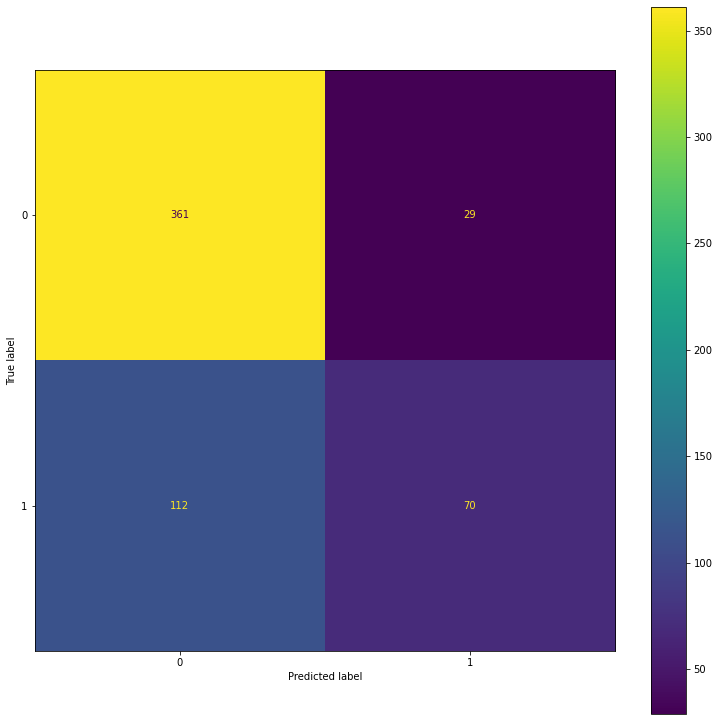

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
build_and_eval_model(lr, X, y)

Running report for model: LinearSVC()


Accuracy 0.793706
Model accuracy score: 0.7937
macro F-1 score : 0.75634
Training-set accuracy score: 0.9974
Training set score: 0.9974
Test set accuracy score: 0.7937
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       390
           1       0.69      0.63      0.66       182

    accuracy                           0.79       572
   macro avg       0.76      0.75      0.76       572
weighted avg       0.79      0.79      0.79       572

Confusion matrix

 [[339  51]
 [ 67 115]]

True Positives(TP) =  339

True Negatives(TN) =  115

False Positives(FP) =  51

False Negatives(FN) =  67
Classification accuracy : 0.7937
Classification error : 0.2063


LinearSVC()

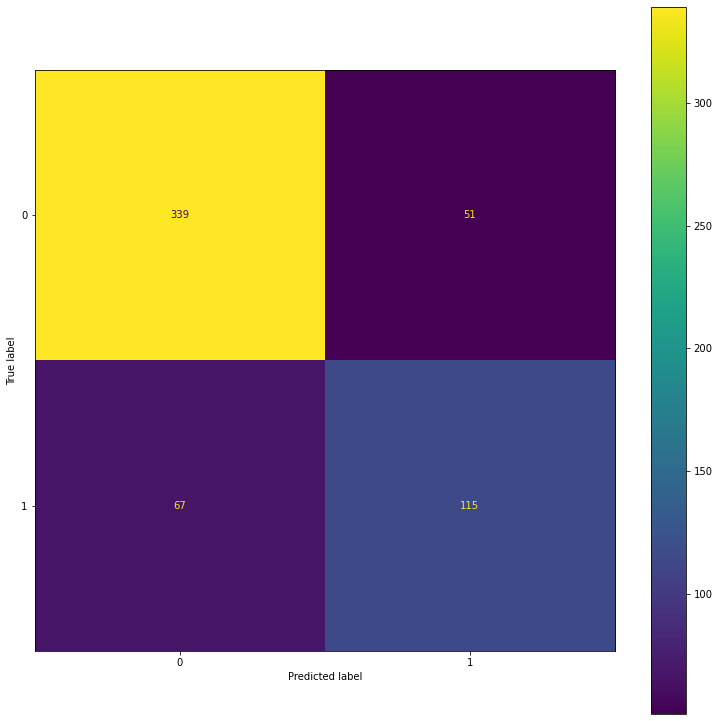

In [180]:
from sklearn import svm

lsvc = svm.LinearSVC()
build_and_eval_model(lsvc, X, y)
# class is imbalanced but not a lot of data is impacting 0 detection better

Running report for model: MultinomialNB(alpha=0.05)


Accuracy 0.748252
Model accuracy score: 0.7483
macro F-1 score : 0.66742
Training-set accuracy score: 0.9943
Training set score: 0.9943
Test set accuracy score: 0.7483
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       390
           1       0.68      0.40      0.50       182

    accuracy                           0.75       572
   macro avg       0.72      0.66      0.67       572
weighted avg       0.74      0.75      0.73       572

Confusion matrix

 [[355  35]
 [109  73]]

True Positives(TP) =  355

True Negatives(TN) =  73

False Positives(FP) =  35

False Negatives(FN) =  109
Classification accuracy : 0.7483
Classification error : 0.2517


MultinomialNB(alpha=0.05)

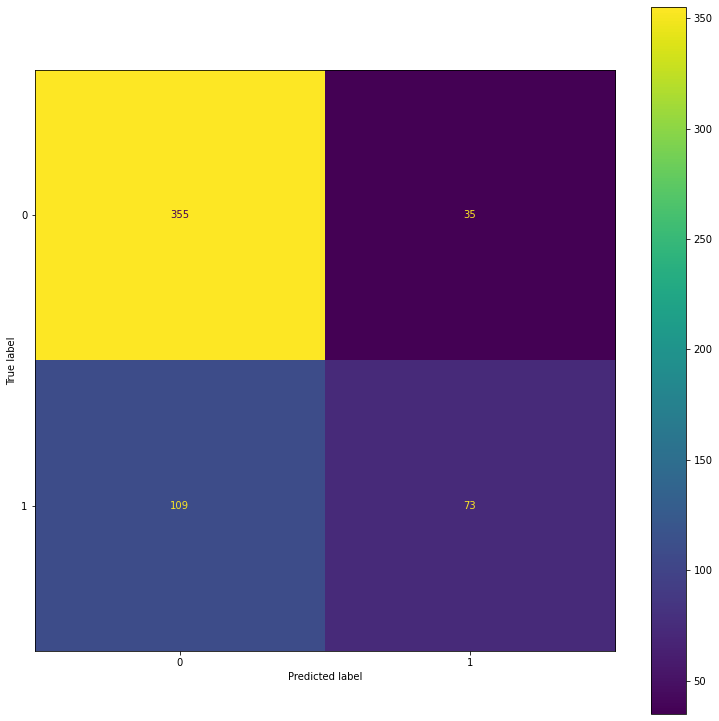

In [186]:
mnb = MultinomialNB(alpha=.05)

# run classifier using 10-fold cross validation
# runs cross validation on dataset to test whether model can generalise over whole dataset
# function returns list of one score per split, and average of scores can be calculated to provide a single metric value for dataset
# MNB_scores = cross_val_score(mnb, X, y, scoring='accuracy', cv=10)
# print(MNB_scores.mean())

build_and_eval_model(mnb, X, y)

Running report for model: SVC()


Accuracy 0.765734
Model accuracy score: 0.7657
macro F-1 score : 0.68909
Training-set accuracy score: 0.9921
Training set score: 0.9921
Test set accuracy score: 0.7657
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       390
           1       0.73      0.42      0.53       182

    accuracy                           0.77       572
   macro avg       0.75      0.67      0.69       572
weighted avg       0.76      0.77      0.75       572

Confusion matrix

 [[361  29]
 [105  77]]

True Positives(TP) =  361

True Negatives(TN) =  77

False Positives(FP) =  29

False Negatives(FN) =  105
Classification accuracy : 0.7657
Classification error : 0.2343


SVC()

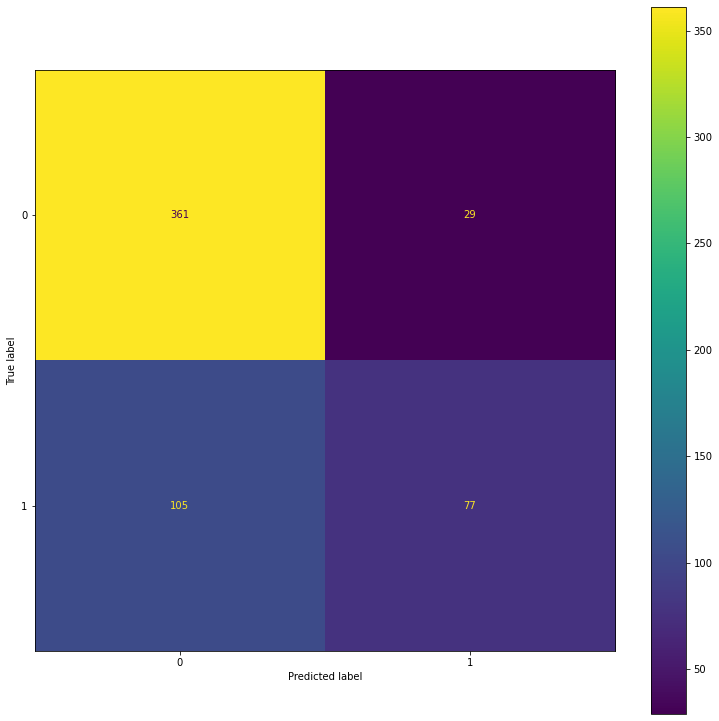

In [183]:
svc = svm.SVC()
build_and_eval_model(svc, X, y)

Running report for model: RandomForestClassifier()


Accuracy 0.767483
Model accuracy score: 0.7675
macro F-1 score : 0.69212
Training-set accuracy score: 0.9996
Training set score: 0.9996
Test set accuracy score: 0.7675
              precision    recall  f1-score   support

           0       0.78      0.93      0.84       390
           1       0.73      0.43      0.54       182

    accuracy                           0.77       572
   macro avg       0.75      0.68      0.69       572
weighted avg       0.76      0.77      0.75       572

Confusion matrix

 [[361  29]
 [104  78]]

True Positives(TP) =  361

True Negatives(TN) =  78

False Positives(FP) =  29

False Negatives(FN) =  104
Classification accuracy : 0.7675
Classification error : 0.2325


RandomForestClassifier()

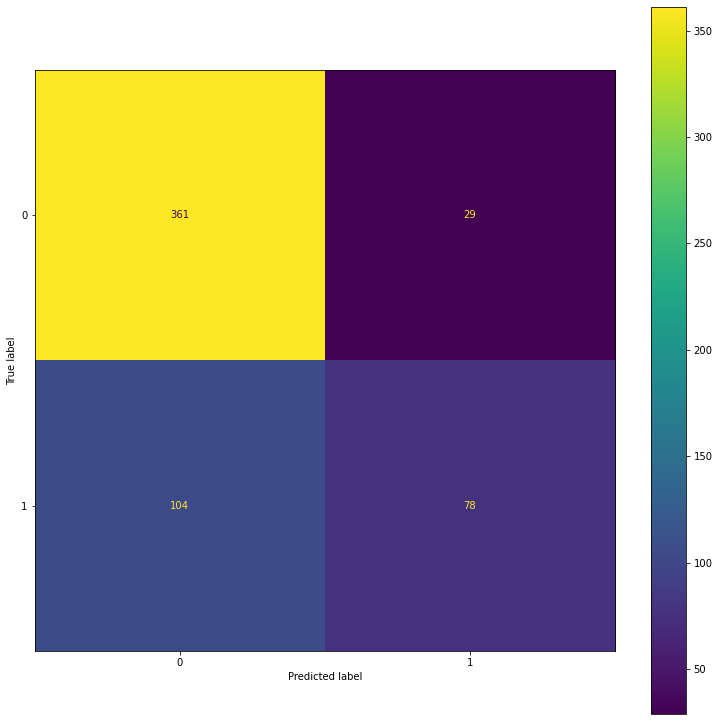

In [184]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

build_and_eval_model(rf, X, y)

In [ ]:
#  a Wilcoxon test, as Vanetik and Mimoun 2022 do, to find the p-value,

In [37]:
# run classifier using 10-fold cross validation
# runs cross validation on dataset to test whether model can generalise over whole dataset
# function returns list of one score per split, and average of scores can be calculated to provide a single metric value for dataset
MNB_scores = cross_val_score(MultinomialNB(), X, y, scoring='accuracy', cv=10)
print(MNB_scores.mean())

nan


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 612, in fit
    X, y = self._check_X_y(X, y)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 477, in _check_X_y
    return self._validate_data(X, y, accept_sparse='csr')
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/

<AxesSubplot:>

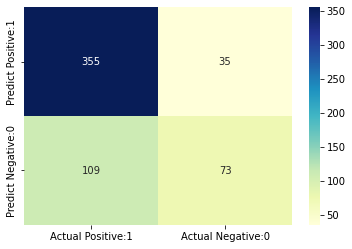

In [46]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')